import numpy as np
import pandas as pd
# ^^^ pyforest auto-imports - don't write above this line
**How many clusters of birthplaces emerge?**

# Imports

In [1]:
import warnings
from clustergram import Clustergram
import urbangrammar_graphics as ugg
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
import pandas
import geopandas as gpd
from shapely.geometry import shape, Point
import pandas as pd
import numpy as np

warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

In [2]:
arena_df = pd.read_csv("data/arenas_w_locations.csv", index_col=0)
arena_gdf = gpd.GeoDataFrame(
            arena_df, geometry=gpd.points_from_xy(arena_df.Lng, arena_df.Lat))
us_can_gdf = gpd.read_file("data/full_us_can_geometry.geojson")

## Data Engineering

In [3]:
# just arena coords
arena_coords = arena_df[['Team_name', 'Lat', 'Lng']]

# Clustergram

K=1 fitted in 0.7698299884796143 seconds.
K=2 fitted in 1.336742877960205 seconds.
K=3 fitted in 1.5707833766937256 seconds.
K=4 fitted in 1.9638879299163818 seconds.
K=5 fitted in 2.1643600463867188 seconds.
K=6 fitted in 2.395801305770874 seconds.


Text(0.5, 1.0, 'K-Means (scikit-learn)')

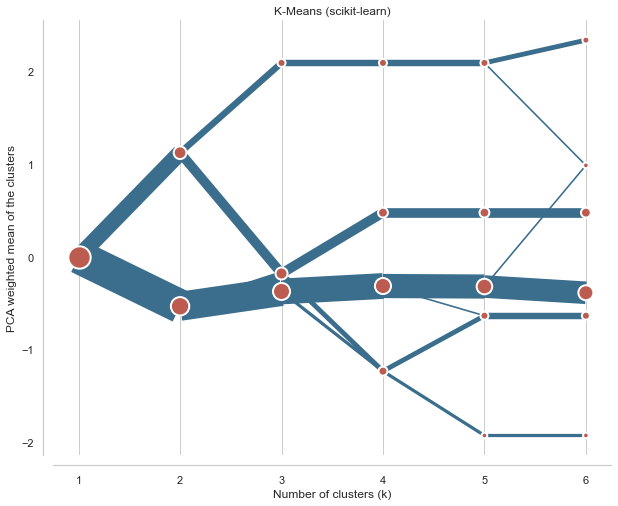

In [4]:
# from the clustergram project page 
data = scale(arena_coords.drop(columns=['Team_name']))

cgram = Clustergram(range(1, 7), n_init=1000, verbose=False)
cgram.fit(data)

ax = cgram.plot(
    figsize=(10, 8),
    line_style=dict(color=ugg.COLORS[1]),
    cluster_style={"color": ugg.COLORS[2]},
)
ax.yaxis.grid(False)
sns.despine(offset=10)

## Analyzing the optimal number of clusters

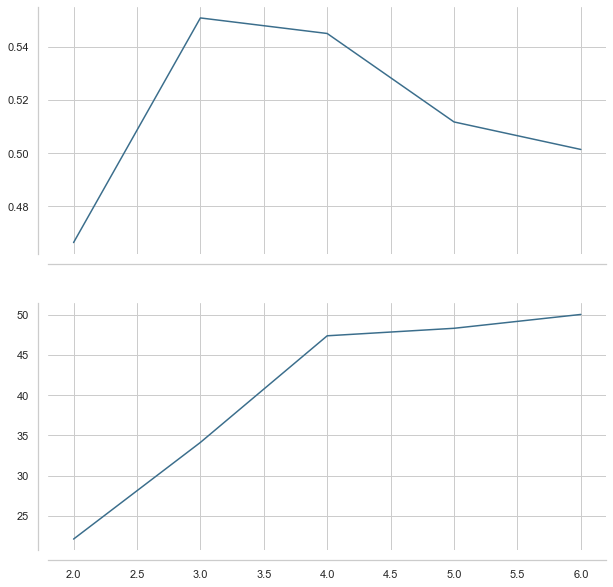

In [5]:
# also from the project page 
fig, axs = plt.subplots(2, figsize=(10, 10), sharex=True)
# score of 1 is best with the silhouette score
cgram.silhouette_score().plot(
#     xlabel="Number of clusters (k)",
#     ylabel="Silhouette score",
    color=ugg.COLORS[1],
    ax=axs[0]
)
# the higher the value, the better
cgram.calinski_harabasz_score().plot(
#     xlabel="Number of clusters (k)",
#     ylabel="Calinski-Harabasz score",
    color=ugg.COLORS[1],
    ax=axs[1]
)
sns.despine(offset=10)

**3 or 4 clusters looks optimal**. Therefore, when we use a clustering algorithm (e.g.: Kmeans), we know the number of clusters for it to create.

# Cluster the data - Kmeans

## With 3 Clusters

In [6]:
# adjusting the data to be an array
X = np.array(arena_coords[['Lat', 'Lng']])

# applying Kmeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

# adding labels to player_gdf
arena_gdf['arena_cluster'] = kmeans.labels_

kmeans.cluster_centers_

# Plotting Data

<AxesSubplot:>

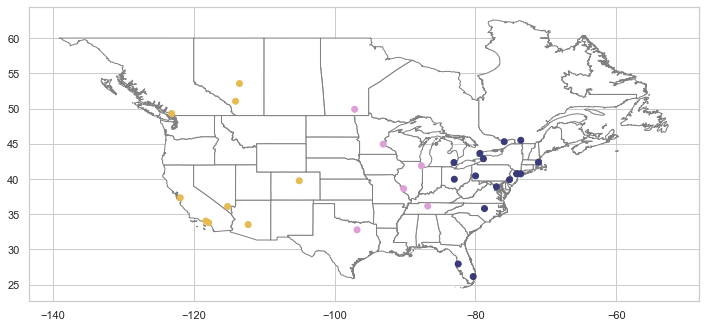

In [23]:
ax = us_can_gdf.plot(figsize = (12, 12), facecolor='white', edgecolor='grey')
# the mis-colored dots in the middle of the larger clusters are the centroids of those clusters
arena_gdf.plot(column='arena_cluster', cmap='tab20b', ax=ax, figsize = (12, 12))

## Adding Centroids to the data

In [11]:
centroid_gdf = gpd.GeoDataFrame(data=[f"Cluster{x}" for x in range(0, 3)], columns = ['Team_name'])

# making the centroids into points
centroid_gdf['geometry'] = [Point(coord[1], coord[0]) for coord in kmeans.cluster_centers_]
centroid_gdf['arena_cluster'] = [x for x in range(4, 7)]
centroid_gdf

In [14]:
# merging the two
arena_gdf_w_centroids = pd.concat([arena_gdf, centroid_gdf])

<AxesSubplot:>

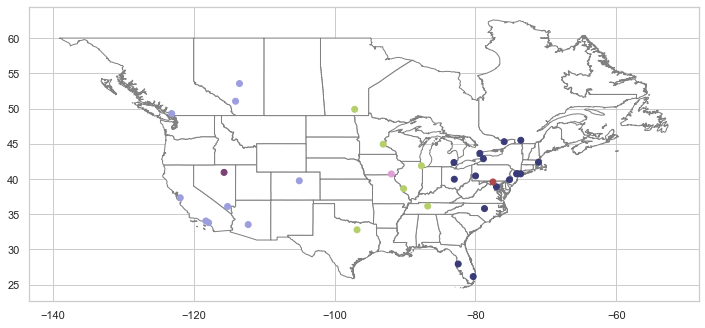

In [22]:
ax1 = us_can_gdf.plot(figsize = (12, 12), facecolor='white', edgecolor='grey')
# the mis-colored dots in the middle of the larger clusters are the centroids of those clusters
arena_gdf_w_centroids.plot(column='arena_cluster', cmap='tab20b', ax=ax1, figsize = (12, 12))
# plt.savefig("pictures/arena_gdf_w_centroids.png", bbox_inches='tight', pad_inches=0.2)

## How many arenas are in each cluster?

In [17]:
# clusters: 0 = east coast, 1 = west coast, 2 = central
# more teams in east coast than west and central (least)
arena_gdf.arena_cluster.value_counts()

0    16
1     9
2     6
Name: arena_cluster, dtype: int64